Summary
-------

On April 15, 1912 the RMS Titanic carrying 2,224 passengers (including crew) struck an iceberg and over the next two hours slid below the icy waves along with over 1,500 dead by the time the RMS Carpathia over 6 hours later.  Oddly enough, the RMS Titanic was actually carrying more lifeboats than required by law which was based on gross tonnage, not number of passengers.  If every life boat has been successfully launched at full capacity (most were not fully loaded and two drifted away as she sunk) there would have only been room for 1,178 in total, still well shy the number of people aboard.

This is an exploration of using machine learning to determine factors in survival.  The dataset is of passengers only (crew numbered about 885 people and a survival rate of around 24%).  Titanic's passengers numbered approximately 1,317 people: 324 in First Class, 284 in Second Class, and 709 in Third Class but this data set has a total pf 1,309 passenger records.  If the RMS Titanic had a full ship of 3,339 passengers and crew the accident would have been much deadlier

The Data
--------

* PassengerId - Unique Identifier
* Survival -Survival (0 = No; 1 = Yes)
* Pclass 1 - First Class, 2 = Second Class, 3 = Third Class
* Name - Last Name, Surname First Name and additional qualifier if needed
* Sex - Male or Female
* Age - Age, Fractional if Age less than One (1) If the Age is Estimated, it is in the form xx.5
* SibSp - Number of Siblings/Spouses Aboard
* Parch - Number of Parents/Children Aboard
* Ticket - Ticket Number
* Fare - Passenger Fare
* Cabin - Cabin with the letter being deck and number is cabin, decks should be A-G
* Embarked - Port where person board (C = Cherbourg; Q = Queenstown; S = Southampton)

As this is my first foray into machine learning, please comment below with any suggestions or notes!  

In [1]:
# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.cross_validation import train_test_split , StratifiedKFold
from sklearn.model_selection import KFold, cross_val_score

from sklearn.feature_selection import RFECV
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

# Visualisation
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
sns.set(style="ticks")


C:\Users\kefor\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Data Importation and Cleaning
---------------------------

First I wanted to get an understanding of the data and see how many are missing values.  At first I need to import from csv's both the training and the test data sets.

In [2]:
# get titanic & test csv files as a DataFrame
train_df = pd.read_csv("~/Desktop/Kaggle---Titanic-Maritime-Machine-Learning/train.csv")
test_df = pd.read_csv("~/Desktop/Kaggle---Titanic-Maritime-Machine-Learning/test.csv")

# if you want to see where values are missing
print("THIS IS THE TRAIN_DF INFO")
train_df.info()
print("-------------------------")
print("THIS IS THE TEST_DF INFO")
test_df.info()



THIS IS THE TRAIN_DF INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
-------------------------
THIS IS THE TEST_DF INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-nu

In [3]:
# Just a quick check of the train_df data, errors are from the NaNs under Age
train_df.describe()

C:\Users\kefor\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,NaN,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,NaN,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,NaN,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Initial View
------------------
Before getting to far into the depths there are a couple of quick visualizations that we should do just to get a feel for the data.  Sex and Age seem to factor heavily into survival but what else can be done to make modeling it more accurate?

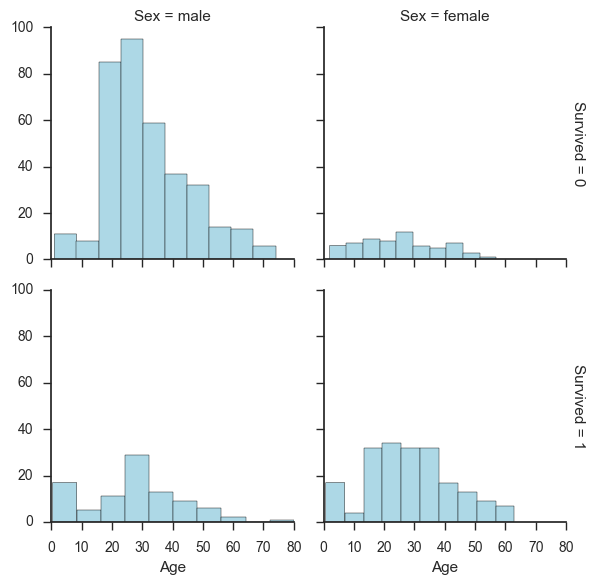

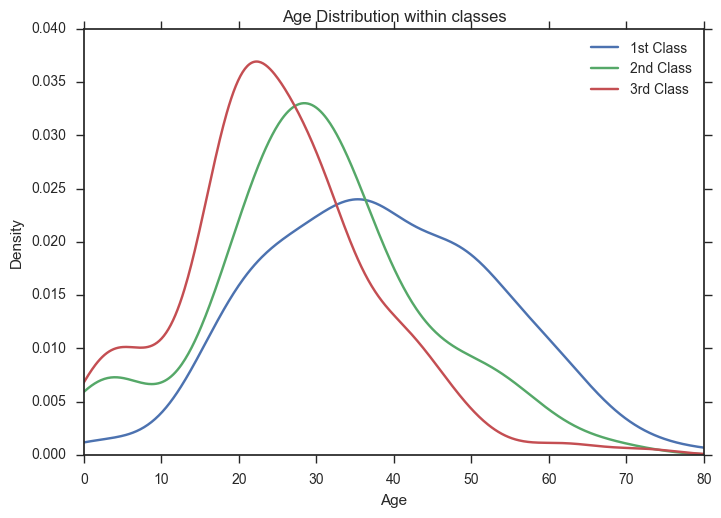

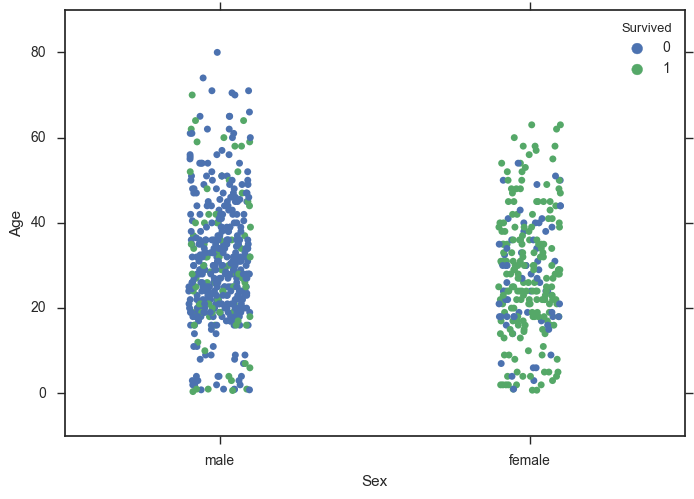

In [4]:
# histogram of Sex and Age split by survival
g = sns.FacetGrid(train_df, col="Sex", row="Survived", margin_titles=True)
g.map(plt.hist,"Age",color="lightblue")
plt.show()
train_df.Age[train_df.Pclass == 1].plot(kind='kde')    
train_df.Age[train_df.Pclass == 2].plot(kind='kde')
train_df.Age[train_df.Pclass == 3].plot(kind='kde')
plt.xlabel("Age")    
plt.title("Age Distribution within classes")
plt.xlim(0,80)
plt.legend(('1st Class', '2nd Class','3rd Class'),loc='best')
plt.show()
sns.stripplot(x="Sex", y="Age", hue="Survived", data=train_df, jitter=True)
plt.show()

A quick check of correlation with survival shows that some features have greater viability than others.  Class and Sex look promising but it is harder to have an clean a correlation with family data.



In [5]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [6]:
train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [7]:
train_df[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean()

,SibSp,Survived
0,0,0.345395
1,1,0.535885
2,2,0.464286
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [8]:
train_df[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean()

,Parch,Survived
0,0,0.343658
1,1,0.550847
2,2,0.500000
3,3,0.600000
4,4,0.000000
5,5,0.200000
6,6,0.000000


Cleaning Data
-------------

There are some missing values, some are simpler than others. The first one is a quick fill for the missing single fare  and embarkment points with the median value.

In [9]:
# Embarked only in train_df, fill the two missing values with the most occurred value, which is "S".
train_df["Embarked"].value_counts() 
train_df["Embarked"] = train_df["Embarked"].fillna("S")

# Fill in the single missing fare with median value
test_df["Fare"].fillna(test_df["Fare"].median(), inplace=True)
                                           
# Convert fare from float to int
train_df['Fare'] = train_df['Fare'].astype(int)
test_df['Fare'] = test_df['Fare'].astype(int)

Family Size
-------

Before tackling the missing Age information, it makes sense to do a little feature engineering now.  First is the simple creation of FamilySize which gives you the overall size of the family.  

Graphing the family size against fare shows a strange slight relationship where the more you paid for the ticket and the larger your family size (2 seems to be the tipping mark), the less likely you were to survive.  

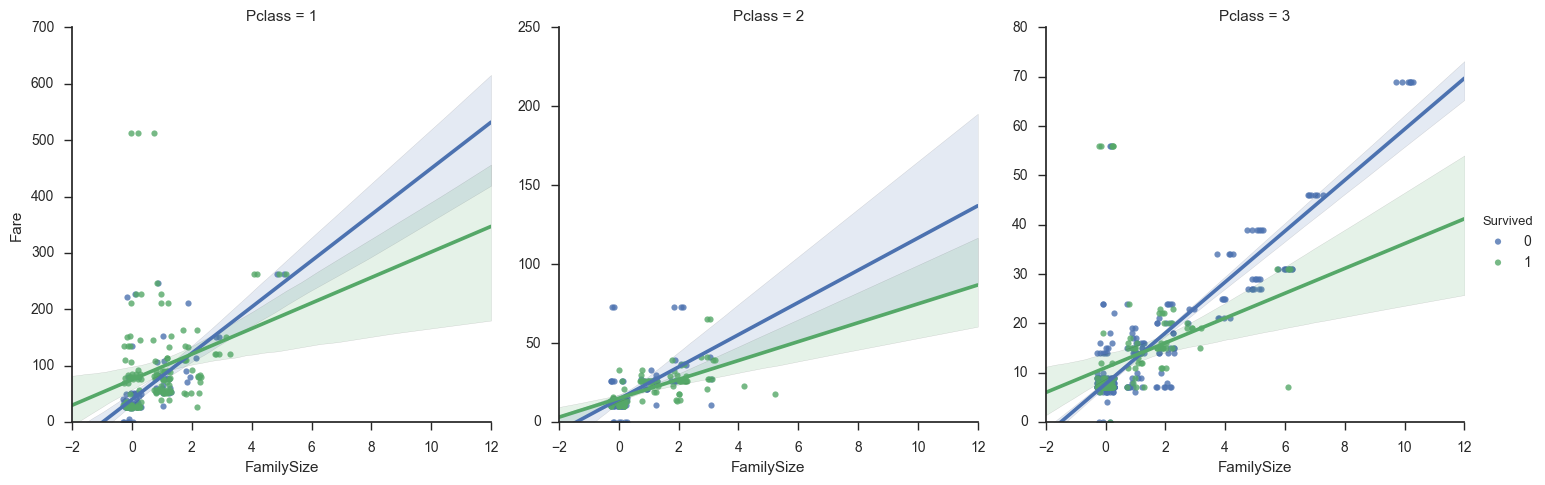

In [10]:
# Create a family size variable
train_df["FamilySize"] = train_df["SibSp"] + train_df["Parch"]
test_df["FamilySize"] = test_df["SibSp"] + test_df["Parch"]

# plot distribution of family size
g = sns.lmplot(x="FamilySize", y="Fare", hue="Survived", col="Pclass",  data=train_df, x_jitter=.3, sharey=False)
g.set(ylim=(0, None))

Name
-------

Next is taking a look at the Names and see what can be extracted. As you can see below there is the last name, a comma, title, First, Middle name and then anything additional in parenthesis.

In [11]:
train_df['Name'].head(5)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

Title
--------

The next step is to split out the title and simplfy the possible iterations.  This will replace the multitude of titles with just five: Mr, Mrs, Miss, Master and Rare Title.  Poonan's work was very helpful and I recommend taking a look at her work: https://www.kaggle.com/poonaml/titanic/titanic-survival-prediction-end-to-end-ml-pipeline 

In [12]:
import re

# function to get the title from a name.
def get_title(name):
    # Use a regular expression to search for a title.  Titles always consist of capital and lowercase letters, and end with a period.
    title_search = re.search(' ([A-Za-z]+)\.', name)
    #If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# Get all the titles
titles = train_df["Name"].apply(get_title)

#Add in the title column with all the current values so we can then manually change them
train_df["Title"] = titles

# Titles with very low cell counts to be combined to "rare" level
rare_title = ['Dona', 'Lady', 'Countess','Capt', 'Col', 'Don', 
                'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer']

# Also reassign mlle, ms, and mme accordingly
train_df.loc[train_df["Title"] == "Mlle", "Title"] = 'Miss'
train_df.loc[train_df["Title"] == "Ms", "Title"] = 'Miss'
train_df.loc[train_df["Title"] == "Mme", "Title"] = 'Mrs'
train_df.loc[train_df["Title"] == "Dona", "Title"] = 'Rare Title'
train_df.loc[train_df["Title"] == "Lady", "Title"] = 'Rare Title'
train_df.loc[train_df["Title"] == "Countess", "Title"] = 'Rare Title'
train_df.loc[train_df["Title"] == "Capt", "Title"] = 'Rare Title'
train_df.loc[train_df["Title"] == "Col", "Title"] = 'Rare Title'
train_df.loc[train_df["Title"] == "Don", "Title"] = 'Rare Title'
train_df.loc[train_df["Title"] == "Major", "Title"] = 'Rare Title'
train_df.loc[train_df["Title"] == "Rev", "Title"] = 'Rare Title'
train_df.loc[train_df["Title"] == "Sir", "Title"] = 'Rare Title'
train_df.loc[train_df["Title"] == "Jonkheer", "Title"] = 'Rare Title'
train_df.loc[train_df["Title"] == "Dr", "Title"] = 'Rare Title'

titles = train_df["Name"].apply(get_title)
# print(pd.value_counts(titles))

#Add in the title column.
test_df["Title"] = titles

# Titles with very low cell counts to be combined to "rare" level
rare_title = ['Dona', 'Lady', 'Countess','Capt', 'Col', 'Don', 
                'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer']

# Also reassign mlle, ms, and mme accordingly
test_df.loc[test_df["Title"] == "Mlle", "Title"] = 'Miss'
test_df.loc[test_df["Title"] == "Ms", "Title"] = 'Miss'
test_df.loc[test_df["Title"] == "Mme", "Title"] = 'Mrs'
test_df.loc[test_df["Title"] == "Dona", "Title"] = 'Rare Title'
test_df.loc[test_df["Title"] == "Lady", "Title"] = 'Rare Title'
test_df.loc[test_df["Title"] == "Countess", "Title"] = 'Rare Title'
test_df.loc[test_df["Title"] == "Capt", "Title"] = 'Rare Title'
test_df.loc[test_df["Title"] == "Col", "Title"] = 'Rare Title'
test_df.loc[test_df["Title"] == "Don", "Title"] = 'Rare Title'
test_df.loc[test_df["Title"] == "Major", "Title"] = 'Rare Title'
test_df.loc[test_df["Title"] == "Rev", "Title"] = 'Rare Title'
test_df.loc[test_df["Title"] == "Sir", "Title"] = 'Rare Title'
test_df.loc[test_df["Title"] == "Jonkheer", "Title"] = 'Rare Title'
test_df.loc[test_df["Title"] == "Dr", "Title"] = 'Rare Title'

print(train_df['Title'].value_counts())
print(test_df['Title'].value_counts())

Mr            517
Miss          185
Mrs           126
Master         40
Rare Title     23
Name: Title, dtype: int64
Mr            228
Miss          101
Mrs            59
Master         23
Rare Title      7
Name: Title, dtype: int64


A quick plot of the titles and survival distribution (remember 1=survived, 0=perished) there are certain trends that are easy to see.  As we discovered earlier Sex was a factor in survival so it is no surprise that the title Mr. was hardest hit.  Master was a term for a young boy but that did not help as much as you would think.  

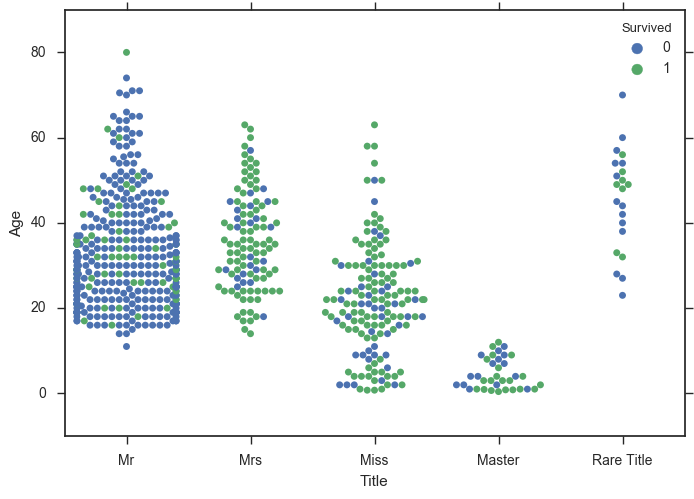

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare Title,0.347826


In [13]:
sns.swarmplot(x="Title", y="Age", hue="Survived", data=train_df)
plt.show()
train_df[["Title", "Survived"]].groupby(['Title'], as_index=False).mean()

Filling Missing Ages
--------------------

There is a fair number of missing age.  First I need to understand what the distribution looks like currently to understand better whether the method I am using to replace the missing data will cause a problem along the line.  There are a wide collection of solutions to this problem across the variety of kernels.  

Mean stacks all the ages in the center, which given that so many are missing, would be unlikely.  There were several uses of regression models but the correlation of features to age are not that particulary strong.  After digging around a bit decided to try a couple of interpolation methods I settled on linear for a fairly even distribution

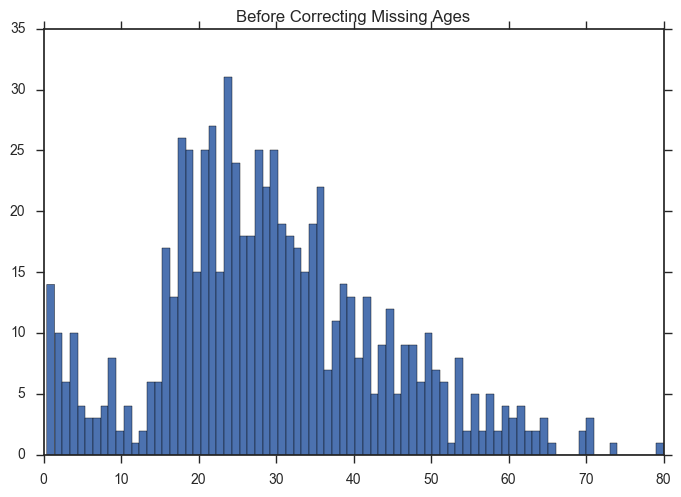

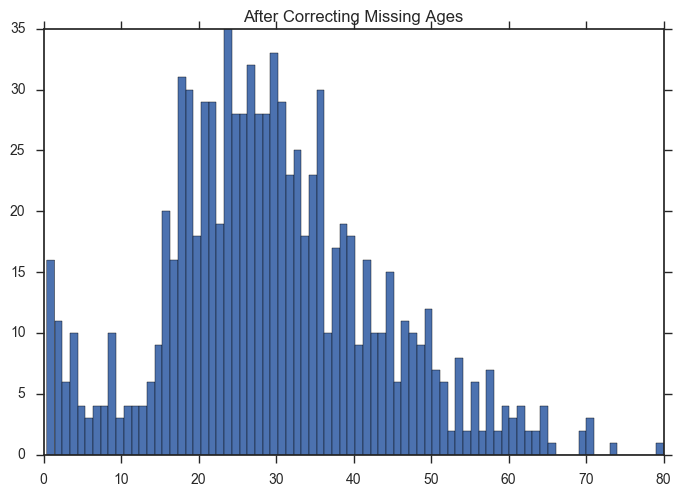

In [14]:
# Plot of Age before filling missing values to visualize the distribution
plt.hist(train_df['Age'].dropna(),bins=80)
plt.title('Before Correcting Missing Ages')
plt.show()

# Fill in all missing values with linear interpolation
train_df['Age']= train_df.Age.fillna(train_df.Age.interpolate(method='linear')) 

# Plot of Age again after linear interpolation was completed
plt.hist(train_df['Age'],bins=80)
plt.title('After Correcting Missing Ages')
plt.show()

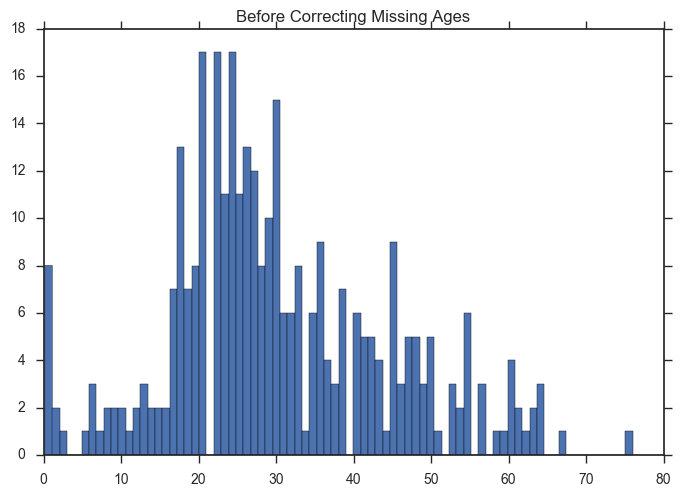

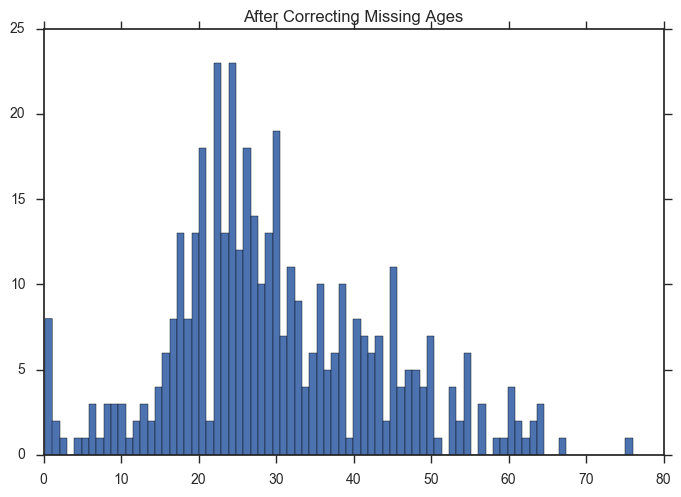

In [15]:
# Plot of Age before filling missing values to visualize the distribution
plt.hist(test_df['Age'].dropna(),bins=80)
plt.title('Before Correcting Missing Ages')
plt.show()

# Fill in all missing values with linear interpolation
test_df['Age']= test_df.Age.fillna(test_df.Age.interpolate(method='linear')) 

# Plot of Age again after linear interpolation was completed
plt.hist(test_df['Age'],bins=80)
plt.title('After Correcting Missing Ages')
plt.show()

Age Bins
---------------------------
In order to get  little more out of the Age, I decided to bin them into subsets with splits and then spent a little time working on refining them.

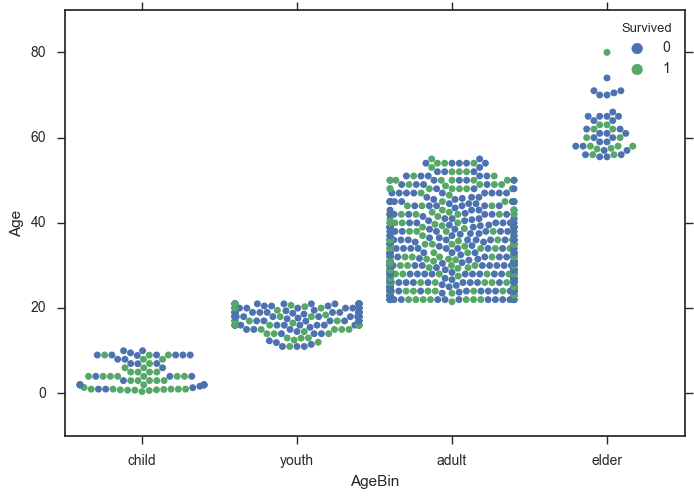

,AgeBin,Survived
0,child,0.563380
1,youth,0.345029
2,adult,0.378512
3,elder,0.318182


In [ ]:
# Used to bin the ages at the points
agepercentile = [0, 10, 21, 55, 81]

# Creates a new column binning the ages in to brackets and labeling them with numbers.  
#train_df["AgeBin"] = pd.cut(train_df['Age'],agepercentile, labels=["1","2","3","4"])
#test_df["AgeBin"] = pd.cut(test_df['Age'],agepercentile, labels=["1","2","3","4"])
train_df["AgeBin"] = pd.cut(train_df['Age'],agepercentile, labels=["child","youth","adult","elder"])
test_df["AgeBin"] = pd.cut(test_df['Age'],agepercentile, labels=["child","youth","adult","elder"])

sns.swarmplot(x="AgeBin", y="Age", hue="Survived", data=train_df)
plt.show()

train_df[["AgeBin", "Survived"]].groupby(['AgeBin'], as_index=False).mean()

Fare Binning
---------
Likewise there is a percentile insight into the fares. I decided to break it into thirds as 2nd Class and 3rd Class overlapped quite a bit in fares. The resulting swarmplot really says it all.

In [ ]:
# This takes the age and breaks it into precentiles
print(np.percentile(train_df['Fare'],[0,33,66,100]))
print(np.percentile(test_df['Fare'],[0,33,66,100]))
farepercentile = [0, 8, 26, 513]

# Creates a new column binning the ages in to brackets and labeling them with numbers.  
# Prencentiles In this case are 0-7, 7=14, 14-31 and 31-513)
train_df["FareBin"] = pd.cut(train_df['Fare'],farepercentile, labels=["Low","Mid","High"])
test_df["FareBin"] = pd.cut(test_df['Fare'],farepercentile, labels=["Low","Mid","High"])

# plot the result
sns.swarmplot(x="FareBin", y="Age", hue="Survived", data=train_df)
plt.show()

train_df[["FareBin", "Survived"]].groupby(['FareBin'], as_index=False).mean()

[   0.    8.   26.  512.]
[   0.    8.   26.  512.]


Assembly of Training Set
-------


In [ ]:
AgeBin = pd.get_dummies( train_df['AgeBin'] , prefix = 'AgeBin')
FareBin = pd.get_dummies( train_df['FareBin'] , prefix = 'FareBin')
Embarked = pd.get_dummies( train_df['Embarked'] , prefix = 'Embarked')
Title = pd.get_dummies( train_df['Title'] , prefix = 'Title')
Sex = pd.get_dummies( train_df['Sex'] , prefix = 'Sex' )
Pclass = pd.get_dummies( train_df['Pclass'] , prefix = 'Pclass')
Age = train_df['Age']
Fare = train_df['Fare']
SibSp = train_df['SibSp']
Parch = train_df['Parch']

In [ ]:
train_X = pd.concat([Age , Fare, SibSp , Parch, Pclass, AgeBin, FareBin, Embarked, Title, Sex], axis=1)
train_X.head()

Assembly of Test Set
-------


In [ ]:
AgeBin = pd.get_dummies( test_df['AgeBin'] , prefix = 'AgeBin')
FareBin = pd.get_dummies( test_df['FareBin'] , prefix = 'FareBin')
Embarked = pd.get_dummies( test_df['Embarked'] , prefix = 'Embarked')
Title = pd.get_dummies( test_df['Title'] , prefix = 'Title')
Sex = pd.get_dummies( test_df['Sex'] , prefix = 'Sex' )
Pclass = pd.get_dummies( test_df['Pclass'] , prefix = 'Pclass')
Age = test_df['Age']
Fare = test_df['Fare']
SibSp = test_df['SibSp']
Parch = test_df['Parch']

In [ ]:
test_X = pd.concat([Age , Fare, SibSp , Parch, Pclass, AgeBin, FareBin, Embarked, Title, Sex], axis=1)
test_X.head()

In [ ]:
corr = train_X.corr()
sns.heatmap(
        corr, 
        square=True )

In [ ]:
# Create all datasets that are necessary to train, validate and test models
train_valid_X = train_X
train_valid_y = train_df.Survived
test_X = test_X
train_X , valid_X , train_y , valid_y = train_test_split( train_valid_X , train_valid_y , train_size = .7 )


In [ ]:
model = RandomForestClassifier(n_estimators=100)

In [ ]:
# model = SVC()

In [ ]:
# model = GradientBoostingClassifier()

In [ ]:
# model = KNeighborsClassifier(n_neighbors = 3)

In [ ]:
model = GaussianNB()

In [ ]:
# model = LogisticRegression()

In [ ]:
model.fit( train_X , train_y )

In [ ]:
# Score the model
print (model.score( train_X , train_y ) , model.score( valid_X , valid_y ))

https://www.kaggle.com/startupsci/titanic/titanic-data-science-solutions

https://www.kaggle.com/helgejo/titanic/an-interactive-data-science-tutorial

https://www.kaggle.com/poonaml/titanic/titanic-survival-prediction-end-to-end-ml-pipeline
